За основу я взяла продвинутое решение задачи кредитного скоринга на данных карточных транзакций: https://github.com/smirnovevgeny/AlfaBattle2.0/tree/master/rnn_baseline/advanced_baseline

А для улучшения результата, по совету с хабра (https://habr.com/ru/companies/alfa/articles/680346/) использовала torch.optim.lr_scheduler.OneCycleLR

### 0. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from typing import List, Dict
from google.colab import files, drive
import gc
from collections import defaultdict

pd.set_option("display.max_columns", None)

In [ ]:
import matplotlib.pyplot as plt

# в стиль добавляем -v0_8-, иначе вылезет предупреждение
plt.style.use("seaborn-v0_8-pastel")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
#чтобы хранить обработанные данные, подключимся к драйву

drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
files.upload();

Saving kaggle.json to kaggle.json


### 1. Data Preprocessing

In [28]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c alfa-bank-pd-credit-history
!unzip -q /content/alfa-bank-pd-credit-history.zip  -d dataset

 97% 361M/372M [00:03<00:00, 134MB/s]
100% 372M/372M [00:03<00:00, 103MB/s]


In [3]:
TRAIN_HIST_PATH = '/content/dataset/data_for_competition/train_data/'
TEST_HIST_PATH = '/content/dataset/data_for_competition/test_data/'

TRAIN_TARGET_PATH = '/content/dataset/data_for_competition/train_target.csv'

In [4]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target.head(5)

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


* Посмотрим, сколько оперативки занимают данные:

In [ ]:
a = pd.read_parquet('/content/dataset/data_for_competition/train_data/train_data_0.pq')
features = a.columns.tolist()[2:]

memory_usage_of_frame = a.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 12
print(f'Объем памяти в  RAM одной партиции данных с кредитными историями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')

del a
gc.collect()

Объем памяти в  RAM одной партиции данных с кредитными историями: 0.964 Gb
Ожидаемый размер в RAM всего датасета: 11.564 Gb


166

* Посчитаем распределение длин кредитных историй и число уникальных значений каждой фичи в тренировочной и тестовой выборках:

In [ ]:
%%time

train_lens = []
test_lens = []
uniques = defaultdict(set)

train_paths = sorted([os.path.join(TRAIN_HIST_PATH, filename) for filename in os.listdir(TRAIN_HIST_PATH)])
test_paths = sorted([os.path.join(TEST_HIST_PATH, filename) for filename in os.listdir(TEST_HIST_PATH)])

for path_to_dataset in train_paths:
    credits_frame = pd.read_parquet(path_to_dataset)
    seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
    train_lens.extend(seq_lens)
    del seq_lens
    gc.collect()

    credits_frame.drop(columns=["id", "rn"], inplace=True)
    for feat in credits_frame.columns.values:
        uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for path_to_dataset in test_paths:
    credits_frame = pd.read_parquet(path_to_dataset)
    seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
    test_lens.extend(seq_lens)
    del seq_lens
    gc.collect()
    
    credits_frame.drop(columns=["id", "rn"], inplace=True)
    for feat in credits_frame.columns.values:
        uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

CPU times: user 28.6 s, sys: 13.3 s, total: 41.9 s
Wall time: 32.7 s


* Сохраним словарь с числом уникальных значений и построим графики распределений длин кредитных историй в тренировочной и тестовой выборках:

In [ ]:
#можно посмотреть на уникальные значения признаков

for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

In [ ]:
with open('/content/uniques.pkl', "wb") as f:
    pickle.dump(uniques, f)

In [ ]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

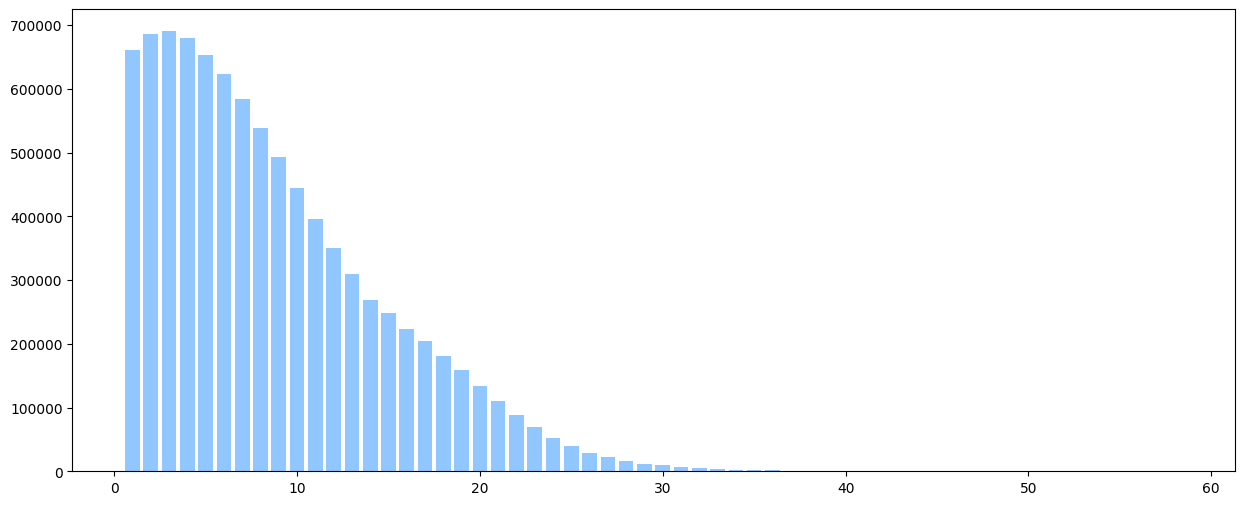

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

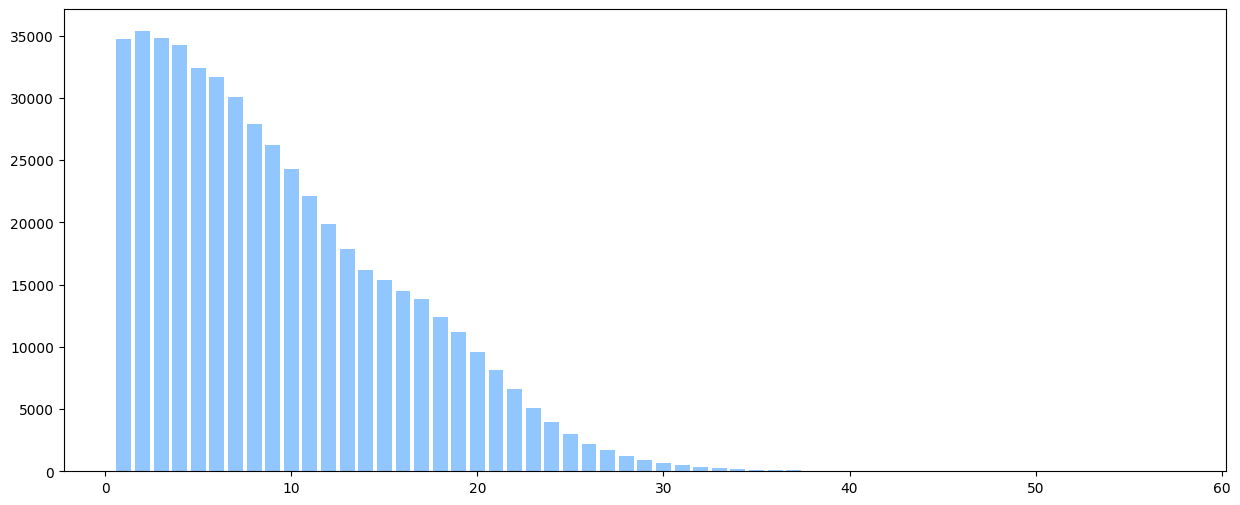

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [ ]:
train_lens.max(), test_lens.max()

(58, 57)

* Создадим словарь, где для каждой длины последовательности указано, до какой длины нужно делать паддинг. Возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [5]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))

* Напишем функции для обработки данных (переводим кредитные истории в последовательности и добавляем паддинг в соответствии с бакетом по длине)


In [6]:
def pad_sequence(array: np.ndarray, max_len: int) -> np.ndarray:
    """
    Принимает на вход массив массивов ``array`` и производит padding каждого вложенного массива до ``max_len``
    """
    
    add_zeros = int(max_len) - len(array[0])
    return np.array([list(x) + [0] * add_zeros for x in array])


def transform_credits_to_sequences(credits_frame: pd.DataFrame, num = 6250) -> pd.DataFrame:
    """
    Принимает pandas.DataFrame с записями кредитных историй клиентов, сортирует кредиты от старых к новым внутри одного клиента
    num - число id, которые будем обрабатывать за раз

    Возвращает новый pandas.DataFrame с двумя колонками: id и sequences.
    Каждое значение в столбце sequences - это массив массивов.
    Каждый вложенный массив - значение одного признака во всех кредитах клиента.
    Всего признаков len(features), поэтому будет len(features) массивов.
    """

    groups = credits_frame \
        .sort_values(['id', 'rn'])\
        .groupby(['id'])
    chunks = [group for _, group in groups]

    del groups
    gc.collect()

    grouped_hist = []
    for i in range(0, len(chunks), num):
        partition = pd.concat(chunk for chunk in chunks[i:i+num]).reset_index(drop=True)
        partition = partition\
                .groupby(['id'])[features]\
                .apply(lambda x: x.values.transpose().tolist())\
                .reset_index().rename(columns={0: 'sequences'})
        partition['sequence_length'] = partition.sequences.apply(lambda x: len(x[1]))
        grouped_hist.append(partition)

    del chunks
    gc.collect()

    return pd.concat(grouped_hist).reset_index(drop=True)


def create_padded_buckets(frame_of_sequences: pd.DataFrame, bucket_info: Dict[int, int],
                          save_to_file_path: str = None, has_target: bool = True):
    """
    Реализует Sequence Bucketing технику для обучения рекуррентных нейронных сетей
    (те не умеют обрабатывать батчи с последовательностями неодинаковой длины).
    Принимает на вход датафрейм с двумя столбцами ("id", "sequences") и словарь ``bucket_info``
    В этом словаре для последовательности каждой длины указано, до какой максимальной длины нужно делать
    padding
    Функция группирует кредиты по бакетам на основе длины, производит padding нулями и сохраняет результат
    в pickle файл, если требуется. Параметр has_target определяет, есть ли в frame_of_sequences целевая переменная
    Возвращает словарь с ключами:  "id", "padded_sequences", "target".
    """

    frame_of_sequences["bucket_idx"] = frame_of_sequences["sequence_length"].map(bucket_info)

    padded_seq = []
    targets = []
    ids = []

    for size, bucket in tqdm(frame_of_sequences.groupby("bucket_idx"), desc="Extracting buckets"):
        padded_sequences = bucket["sequences"].apply(lambda x: pad_sequence(x, size)).values
        padded_sequences = np.array([np.array(x) for x in padded_sequences])
        padded_seq.append(padded_sequences)

        if has_target:
            targets.append(bucket["flag"].values)

        ids.append(bucket["id"].values)

    frame_of_sequences.drop(columns=["bucket_idx"], inplace=True)

    dict_result = {
        "id": np.array(ids),
        "padded_sequences": np.array(padded_seq),
        "target": np.array(targets) if targets else []
    }

    if save_to_file_path:
        with open(save_to_file_path, "wb") as f:
            pickle.dump(dict_result, f)
    return dict_result

In [7]:
def create_buckets_from_credits(path_to_dataset
                                , save_to_path, frame_with_ids = None
                                , has_target=False):
    """
    Формирует фрейм с кредитами в виде последовательностей с помощью transform_hist_to_sequences
    Если указан frame_with_ids, использует id из frame_with_ids - это актуально при выделении валидационной выборки
    Реализует технику sequence_bucketing и сохраняет словарь обработанных последовательностей в .pkl файл
    """

    block = 0
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)])
    
    for path_to_dataset in dataset_paths:
        
        credits_frame = pd.read_parquet(path_to_dataset)
        #перед паддингом будем сдвигать все значения на 1, т.к. паддинг будет нулями, а значения признаков тоже начинаются с 0
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)

        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on='id')

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = '00' + block_as_str
        else:
            block_as_str = '0' + block_as_str

        processed_fragment = create_padded_buckets(seq, bucket_info,
                                                   has_target=has_target, 
                                                   save_to_file_path=os.path.join(save_to_path, f'processed_chunk_{block_as_str}.pkl'))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Для валидации случайным образом выберем 10% обучающих данных.

In [ ]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [ ]:
%%time
! rm -r /content/train_buckets
! mkdir /content/train_buckets

create_buckets_from_credits(TRAIN_HIST_PATH,
                            save_to_path='/content/train_buckets',
                            frame_with_ids=train,
                            has_target=True)

Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 14min, sys: 1min 29s, total: 15min 29s
Wall time: 15min 38s


In [ ]:
!cp -r '/content/train_buckets' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
%%time
! rm -r /content/val_buckets
! mkdir /content/val_buckets

create_buckets_from_credits(TRAIN_HIST_PATH,
                            save_to_path='/content/val_buckets',
                            frame_with_ids=val,
                            has_target=True)

rm: cannot remove '/content/val_buckets': No such file or directory


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 10min 59s, sys: 1min 7s, total: 12min 7s
Wall time: 12min 24s


In [ ]:
!cp -r '/content/val_buckets' '/content/drive/My Drive/Colab Notebooks'

### 2. Modeling

In [3]:
def batches_generator(list_of_paths: List[str], batch_size: int = 32, shuffle: bool = False,
                      is_infinite: bool = False, verbose: bool = False, device: torch.device = None, is_train: bool = True):
    """
    Итеративно возвращает батчи на вход рекуррентных нейронных сетей
    """
    
    while True:
        if shuffle:
            np.random.shuffle(list_of_paths)

        for path in list_of_paths:
            if verbose:
                print(f"Reading {path}")

            with open(path, "rb") as f:
                data = pickle.load(f)

            ids, padded_sequences, targets = data["id"], data["padded_sequences"], data["target"]
            indices = np.arange(len(ids))
            if shuffle:
                np.random.shuffle(indices)
                ids = ids[indices]
                padded_sequences = padded_sequences[indices]
                if is_train:
                    targets = targets[indices]

            for idx in range(len(ids)):
                bucket_ids = ids[idx]
                bucket = padded_sequences[idx]
                if is_train:
                    bucket_targets = targets[idx]

                for jdx in range(0, len(bucket), batch_size):
                    batch_ids = bucket_ids[jdx: jdx + batch_size]
                    batch_sequences = bucket[jdx: jdx + batch_size]
                    if is_train:
                        batch_targets = bucket_targets[jdx: jdx + batch_size]

                    batch_sequences = [torch.LongTensor(batch_sequences[:, i]).to(device) for i in range(len(features))]
                    if is_train:
                        yield dict(id_=batch_ids,
                                    features=batch_sequences,
                                    label=torch.LongTensor(batch_targets).to(device))
                    else:
                        yield dict(id_=batch_ids,
                                    features=batch_sequences)
        if not is_infinite:
            break

In [4]:
from sklearn.metrics import roc_auc_score

def train_epoch(model: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler, dataset_train: List[str],
                batch_size: int = 64, shuffle: bool = True, print_loss_every_n_batches: int = 500,
                device: torch.device = None):
    """
    Делает одну эпоху обучения модели, логируя промежуточные значения функции потерь
    """
    model.train()
    loss_function = nn.BCEWithLogitsLoss(reduction="none")
    losses = torch.LongTensor().to(device)
    samples_counter = 0
    train_generator = batches_generator(dataset_train, batch_size=batch_size, shuffle=shuffle,
                                        device=device, is_train=True)

    for num_batch, batch in tqdm(enumerate(train_generator, start=1), desc="Training"):
        output = torch.flatten(model(batch["features"]))
        batch_loss = loss_function(output, batch["label"].float())
        batch_loss.mean().backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        samples_counter += batch_loss.size(0)

        losses = torch.cat([losses, batch_loss], dim=0)
        if num_batch % print_loss_every_n_batches == 0:
            print(f"Batches {num_batch - print_loss_every_n_batches + 1} - {num_batch} loss:"
                  f"{losses[-samples_counter:].mean()}", end="\r")
            samples_counter = 0

    print(f"Training loss after epoch: {losses.mean()}", end="\r")


def eval_model(model: torch.nn.Module, dataset_val: List[str], batch_size: int = 32, device: torch.device = None) -> float:
    """
    Скорит выборку моделью и вычисляет метрику ROC AUC
    """
    model.eval()
    preds = []
    targets = []
    val_generator = batches_generator(dataset_val, batch_size=batch_size, shuffle=False,
                                      device=device, is_train=True)

    for batch in tqdm(val_generator, desc="Evaluating model"):
        targets.extend(batch["label"].detach().cpu().numpy().flatten())
        output = model(batch["features"])
        preds.extend(output.detach().cpu().numpy().flatten())

    return roc_auc_score(targets, preds)


def inference(model: torch.nn.Module, dataset_test: List[str], batch_size: int = 32, device: torch.device = None) -> pd.DataFrame:
    """
    Делает предикты на новых данных и готовит фрейм для проверяющей системы
    """
    model.eval()
    preds = []
    ids = []
    test_generator = batches_generator(dataset_test, batch_size=batch_size, shuffle=False,
                                       verbose=False, device=device, is_train=False)

    for batch in tqdm(test_generator, desc="Test predictions"):
        ids.extend(batch["id_"])
        output = model(batch["features"])
        preds.extend(output.detach().cpu().numpy().flatten())

    return pd.DataFrame({
        "id": ids,
        "score": preds
    })

In [5]:
class EarlyStopping:
    """
    Останавливает обучение модели, если валидационная метрика не улучшается в течение заданного числа эпох
    """

    def __init__(self, patience=7, mode='min', verbose=False, delta=0, save_path='checkpoint.hdf5', metric_name=None, save_format='torch'):
        if mode not in ["min", "max"]:
            raise ValueError(f"Unrecognized mode: {mode}! Please choose one of the following modes: \"min\", \"max\"")

        if save_format not in ["torch", "tf"]:
            raise ValueError(f"Unrecognized format: {save_format}! Please choose one of the following formats: \"torch\", \"tf\"")

        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_prev_score = np.Inf if mode == "min" else -np.Inf
        self.delta = delta
        self.save_path = save_path
        self.metric_name = "metric" if not metric_name else metric_name
        self.save_format = save_format

    def __call__(self, metric_value, model):

        score = -metric_value if self.mode == "min" else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                f"No imporvement in validation {self.metric_name}. Current: {score:.6f}. Current best: {self.best_score:.6f}")
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value: float, model: torch.nn.Module):
        """
        Cохраняет модель, если валидационная метрика улучшилась
        """
        if self.verbose:
            print(
                f"Validation {self.metric_name} improved ({self.best_prev_score:.6f} --> {metric_value:.6f}).  Saving model...")
        if self.save_format == "tf":
            model.save_weights(self.save_path)
        else:
            torch.save(model.state_dict(), self.save_path)

        self.best_prev_score = metric_value

* Для представления признаков в модели будем использовать категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [6]:
with open('/content/uniques.pkl', 'rb') as f:
    uniques = pickle.load(f)

In [7]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [8]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель

In [9]:
class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32):
        super(CreditsRNN, self).__init__()
        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature],padding_idx=None) 
                                                          for feature in features])
        self._spatial_dropout = nn.Dropout2d(0.15)
        self._credits_cat_embeddings_concated_dim = sum([embedding_projections[x][1] for x in features])
        
        self._gru = nn.GRU(input_size=self._credits_cat_embeddings_concated_dim,
                             hidden_size=rnn_units, batch_first=True, bidirectional=True)
        
        self._hidden_size = rnn_units
        
        pooling_result_dimension = self._hidden_size * 2
         
        self._top_classifier = nn.Sequential(nn.Linear(in_features=2*pooling_result_dimension, 
                                                       out_features=top_classifier_units),
                                             nn.ReLU(),
                                             nn.Linear(in_features=top_classifier_units, out_features=1)
                                            )
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        concated_embeddings = concated_embeddings.permute(0, 2, 1).unsqueeze(3)
        
        dropout_embeddings = self._spatial_dropout(concated_embeddings)
        dropout_embeddings = dropout_embeddings.squeeze(3).permute(0, 2, 1)

        states, _ = self._gru(dropout_embeddings)
        
        rnn_max_pool = states.max(dim=1)[0]
        rnn_avg_pool = states.sum(dim=1) / states.shape[1]        
                
        combined_input = torch.cat([rnn_max_pool, rnn_avg_pool], dim=-1) #-1
            
        logit = self._top_classifier(combined_input)        
        return logit
    
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

### 3. Training

In [10]:
!rm -rf /content/checkpoints
!mkdir /content/checkpoints

In [11]:
path_to_checkpoints = "/content/checkpoints/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"), 
                   metric_name="ROC-AUC", save_format="torch")

In [12]:
num_epochs = 15
train_batch_size = 128
val_batch_size = 128

In [13]:
features = ["pre_since_opened", "pre_since_confirmed", "pre_pterm", "pre_fterm", "pre_till_pclose", "pre_till_fclose",
            "pre_loans_credit_limit", "pre_loans_next_pay_summ", "pre_loans_outstanding", "pre_loans_total_overdue",
            "pre_loans_max_overdue_sum", "pre_loans_credit_cost_rate",
            "pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90",
            "is_zero_loans5", "is_zero_loans530", "is_zero_loans3060", "is_zero_loans6090", "is_zero_loans90",
            "pre_util", "pre_over2limit", "pre_maxover2limit", "is_zero_util", "is_zero_over2limit", "is_zero_maxover2limit",
            "enc_paym_0", "enc_paym_1", "enc_paym_2", "enc_paym_3", "enc_paym_4", "enc_paym_5", "enc_paym_6", "enc_paym_7", "enc_paym_8",
            "enc_paym_9", "enc_paym_10", "enc_paym_11", "enc_paym_12", "enc_paym_13", "enc_paym_14", "enc_paym_15", "enc_paym_16",
            "enc_paym_17", "enc_paym_18", "enc_paym_19", "enc_paym_20", "enc_paym_21", "enc_paym_22", "enc_paym_23", "enc_paym_24",
            "enc_loans_account_holder_type", "enc_loans_credit_status", "enc_loans_credit_type", "enc_loans_account_cur",
            "pclose_flag", "fclose_flag"]

In [14]:
model = CreditsRNN(features, embedding_projections).to(device)

In [15]:
model

CreditsRNN(
  (_credits_cat_embeddings): ModuleList(
    (0): Embedding(21, 9)
    (1-2): 2 x Embedding(19, 8)
    (3-4): 2 x Embedding(18, 8)
    (5): Embedding(17, 8)
    (6): Embedding(21, 9)
    (7): Embedding(9, 5)
    (8): Embedding(7, 4)
    (9): Embedding(3, 2)
    (10): Embedding(5, 3)
    (11): Embedding(15, 7)
    (12): Embedding(19, 8)
    (13): Embedding(21, 9)
    (14): Embedding(11, 6)
    (15): Embedding(7, 4)
    (16): Embedding(21, 9)
    (17-21): 5 x Embedding(3, 2)
    (22-24): 3 x Embedding(21, 9)
    (25-27): 3 x Embedding(3, 2)
    (28-38): 11 x Embedding(5, 3)
    (39): Embedding(6, 4)
    (40-47): 8 x Embedding(5, 3)
    (48): Embedding(6, 4)
    (49-51): 3 x Embedding(5, 3)
    (52): Embedding(6, 4)
    (53-54): 2 x Embedding(8, 5)
    (55): Embedding(9, 5)
    (56): Embedding(5, 3)
    (57-58): 2 x Embedding(3, 2)
  )
  (_spatial_dropout): Dropout2d(p=0.15, inplace=False)
  (_gru): GRU(258, 128, batch_first=True, bidirectional=True)
  (_top_classifier): Seque

In [16]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

In [17]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=21094, epochs=15)

In [18]:
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/train_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_train

['/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_000.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_001.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_002.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_003.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_004.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_005.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_006.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_007.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_008.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_009.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_010.pkl',
 '/content/drive/MyDrive/Colab Notebooks/train_buckets/processed_chunk_011.pkl']

In [19]:
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/val_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_val = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_val

['/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_000.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_001.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_002.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_003.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_004.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_005.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_006.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_007.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_008.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_009.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_010.pkl',
 '/content/drive/MyDrive/Colab Notebooks/val_buckets/processed_chunk_011.pkl']

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохранять веса после каждой эпохи, а также лучшие с помощью early_stopping.

In [20]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, scheduler, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (-inf --> 0.761426).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 1 completed. Train ROC AUC: 0.7627269662044527, val ROC AUC: 0.7614264535264247
Starting epoch 2


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.761426 --> 0.762028).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 2 completed. Train ROC AUC: 0.7647960343632599, val ROC AUC: 0.7620275364046205
Starting epoch 3


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.762028 --> 0.776360).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 3 completed. Train ROC AUC: 0.7817480646249734, val ROC AUC: 0.7763599023369062
Starting epoch 4


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.776360 --> 0.777353).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 4 completed. Train ROC AUC: 0.7838032531017856, val ROC AUC: 0.7773526551905433
Starting epoch 5


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

Validation ROC-AUC improved (0.777353 --> 0.780769).  Saving model...


Evaluating model: 0it [00:00, ?it/s]

Epoch 5 completed. Train ROC AUC: 0.7897752538493926, val ROC AUC: 0.780768556335989
Starting epoch 6


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.780737. Current best: 0.780769
EarlyStopping counter: 1 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 6 completed. Train ROC AUC: 0.7921735940460267, val ROC AUC: 0.7807372822110625
Starting epoch 7


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.777713. Current best: 0.780769
EarlyStopping counter: 2 out of 3


Evaluating model: 0it [00:00, ?it/s]

Epoch 7 completed. Train ROC AUC: 0.7900373724501447, val ROC AUC: 0.7777131037354557
Starting epoch 8


Training: 0it [00:00, ?it/s]

Evaluating model: 0it [00:00, ?it/s]

No imporvement in validation ROC-AUC. Current: 0.780569. Current best: 0.780769
EarlyStopping counter: 3 out of 3
Early stopping reached. Stop training...
CPU times: user 56min 6s, sys: 2min 25s, total: 58min 32s
Wall time: 1h 18min 42s


### 4. Submission

* Подготовим фрейм для проверяющей системы

In [17]:
model.load_state_dict(torch.load('/content/checkpoints/best_checkpoint.pt'))

<All keys matched successfully>

In [18]:
%%time
! rm -r /content/test_buckets
! mkdir /content/test_buckets

create_buckets_from_credits(TEST_HIST_PATH,
                            save_to_path='/content/test_buckets')

Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 1min 56s, sys: 14.8 s, total: 2min 10s
Wall time: 2min 21s


In [19]:
path_to_dataset = '/content/test_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_test = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_test

['/content/test_buckets/processed_chunk_000.pkl',
 '/content/test_buckets/processed_chunk_001.pkl']

In [20]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

Test predictions: 0it [00:00, ?it/s]

In [21]:
test_preds.head()

,id,score
0,3000014,-3.554033
1,3000020,-1.567900
2,3000027,-3.051518
3,3000043,-2.081464
4,3000049,-3.603256


In [22]:
test_preds.shape

(500000, 2)

In [23]:
test_preds.to_csv("torch_submission.csv", index=None)

In [ ]:
!cp -r '/content/torch_submission.csv' '/content/drive/My Drive/Colab Notebooks'